## Open notebook in:
| Colab                                 
:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nicolepcx/transformers-the-definitive-guide/blob/master/CH03/ch03_image_classification.ipynb)                                             

# About this Notebook

This code demonstrates the process of fine-tuning a pre-trained image classification model on a custom dataset using Hugging Face's `transformers` library. In this example, you use the `SwinV2` model for classifying images of snacks from a dataset.

### Steps Included:

1. **Dataset Loading and Preparation**:  
   The `Matthijs/snacks` dataset is loaded, and label mappings are created to convert between label names and indices.

2. **Data Preprocessing**:  
   You use an `ImageProcessor` class to handle image transformations, including resizing, cropping, normalization, and conversion to tensors. These transformations ensure that the input images are appropriately preprocessed before being fed into the model.

3. **Model Setup**:  
   The `AutoModelForImageClassification` is loaded with the pre-trained `SwinV2` model. You also use the `TrainingArguments` object, which specifies hyperparameters and training configurations like learning rate, batch size, number of epochs, and evaluation strategy.

4. **Training the Model**:  
   The `Trainer` class is used to manage the training loop, leveraging the processed datasets, model, training arguments, and a custom metric computation function (accuracy). The trainer also handles model evaluation and saving the best model based on performance metrics.

5. **Model Evaluation and Saving**:  
   After training, the model is evaluated on the validation dataset, and the final metrics are logged and saved. The trained model, along with the image processor, is saved for later use.

6. **Inference Pipeline**:  
   Finally, a pipeline is created using the fine-tuned model and image processor, allowing us to classify new images and test the model's performance on unseen data.


# Installs

In [ ]:
!pip install -q datasets==2.21.0 transformers==4.42.4 accelerate==0.32.1 evaluate==0.4.2 -qqq

# Imports

In [ ]:
import numpy as np
import torch
from datasets import load_dataset
import evaluate

from transformers import (
    AutoModelForImageClassification,
    AutoImageProcessor,
    TrainingArguments,
    Trainer,
    pipeline
)

from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    Resize,
    ToTensor,
)

In [ ]:
MODEL_PATH = "microsoft/swinv2-tiny-patch4-window8-256"
BATCH_SIZE = 16

# Get the Dataset

In [ ]:
dataset = load_dataset("Matthijs/snacks")

Generating train split:   0%|          | 0/4838 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/952 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/955 [00:00<?, ? examples/s]

In [ ]:
metric = evaluate.load("accuracy")

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4838
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 952
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 955
    })
})

## Print the Labels

In [ ]:
print(dataset["train"].features['label'].names)

['apple', 'banana', 'cake', 'candy', 'carrot', 'cookie', 'doughnut', 'grape', 'hot dog', 'ice cream', 'juice', 'muffin', 'orange', 'pineapple', 'popcorn', 'pretzel', 'salad', 'strawberry', 'waffle', 'watermelon']


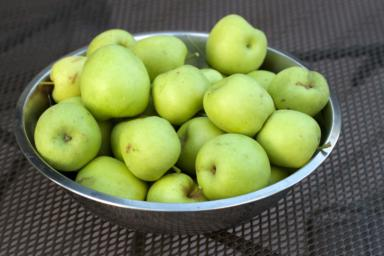

In [ ]:
dataset['test'][1]['image']

In [ ]:
labels = dataset["train"].features["label"].names
num_labels = len(dataset["train"].features["label"].names)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [ ]:
print(label2id)
print(id2label)

{'apple': 0, 'banana': 1, 'cake': 2, 'candy': 3, 'carrot': 4, 'cookie': 5, 'doughnut': 6, 'grape': 7, 'hot dog': 8, 'ice cream': 9, 'juice': 10, 'muffin': 11, 'orange': 12, 'pineapple': 13, 'popcorn': 14, 'pretzel': 15, 'salad': 16, 'strawberry': 17, 'waffle': 18, 'watermelon': 19}
{0: 'apple', 1: 'banana', 2: 'cake', 3: 'candy', 4: 'carrot', 5: 'cookie', 6: 'doughnut', 7: 'grape', 8: 'hot dog', 9: 'ice cream', 10: 'juice', 11: 'muffin', 12: 'orange', 13: 'pineapple', 14: 'popcorn', 15: 'pretzel', 16: 'salad', 17: 'strawberry', 18: 'waffle', 19: 'watermelon'}


In [ ]:
image_processor  = AutoImageProcessor.from_pretrained(MODEL_PATH)
image_processor

preprocessor_config.json:   0%|          | 0.00/240 [00:00<?, ?B/s]

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 256,
    "width": 256
  }
}

# Preprocess the data

In [ ]:
class ImageProcessor:
    """
    A class to preprocess and transform images for a machine learning pipeline.

    This class handles the initialization of a set of image transformations based
    on the input configuration provided through the `image_processor` object. The
    transformations include resizing, cropping, converting to tensors, and normalizing
    images to prepare them for model ingestion.

    Attributes:
    -----------
    normalize : Normalize
        A normalization transformation initialized with mean and standard deviation values.
    size : tuple or int
        The target size for resizing images. This could either be a tuple (height, width)
        for fixed-size resizing or an integer for resizing based on the shortest edge.
    crop_size : tuple
        The dimensions for cropping images. When `size` is based on the shortest edge,
        this is a square crop; otherwise, it matches the size dimensions.
    max_size : int or None
        The maximum size for resizing the longest edge of the image. This is only set when
        resizing based on the shortest edge.
    transforms : Compose
        A composed list of transformations that are applied sequentially to the images.

    Methods:
    --------
    preprocess(example_batch):
        Applies the predefined transformations to a batch of images, converting each
        image to RGB format and then transforming it. Returns the transformed batch.
    """

    def __init__(self, image_processor):
        self.normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

        if "height" in image_processor.size:
            self.size = (image_processor.size["height"], image_processor.size["width"])
            self.crop_size = self.size
            self.max_size = None
        elif "shortest_edge" in image_processor.size:
            self.size = image_processor.size["shortest_edge"]
            self.crop_size = (self.size, self.size)
            self.max_size = image_processor.size.get("longest_edge")

        self.transforms = Compose([
            Resize(self.size),
            CenterCrop(self.crop_size),
            ToTensor(),
            self.normalize,
        ])

    def preprocess(self, example_batch):
        """Apply transforms across a batch."""
        example_batch["pixel_values"] = [
            self.transforms(image.convert("RGB")) for image in example_batch["image"]
        ]
        return example_batch

In [ ]:
train_ds = dataset['train']
val_ds = dataset['validation']

# Load the Model and Image Processor

In [ ]:
processor = ImageProcessor(image_processor)

train_ds.set_transform(processor.preprocess)
val_ds.set_transform(processor.preprocess)

In [ ]:
model = AutoModelForImageClassification.from_pretrained(
    MODEL_PATH,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True,
)

config.json:   0%|          | 0.00/69.9k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/113M [00:00<?, ?B/s]

Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-tiny-patch4-window8-256 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([20, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([20]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Train the Model

In [ ]:
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
model_name = MODEL_PATH.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-snacks",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=5,
    warmup_ratio=0.2,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Then we just need to pass all of this along with our datasets to the `Trainer`:

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy
0,1.796300,1.112141,0.687958
1,0.545300,0.403339,0.872251
2,0.307400,0.287914,0.912042
4,0.116900,0.243455,0.924607


***** train metrics *****
  epoch                    =      4.9505
  total_flos               = 726351278GF
  train_loss               =      0.7824
  train_runtime            =  0:05:21.84
  train_samples_per_second =       75.16
  train_steps_per_second   =       1.165


We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [ ]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =     4.9505
  eval_accuracy           =     0.9246
  eval_loss               =     0.2435
  eval_runtime            = 0:00:04.85
  eval_samples_per_second =     196.71
  eval_steps_per_second   =     12.359


In [ ]:
name =f"{model_name}-finetuned-snacks"
name

'swinv2-tiny-patch4-window8-256-finetuned-snacks'

## Save the model

In [ ]:

model.save_pretrained(name)
image_processor.save_pretrained(name)

['swinv2-tiny-patch4-window8-256-finetuned-snacks/preprocessor_config.json']

## Validate Classification

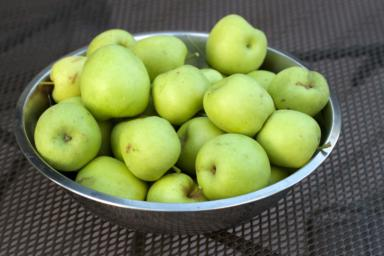

In [ ]:
image = dataset['test'][1]['image']
image

In [ ]:
image_processor = AutoImageProcessor.from_pretrained(name)
model = AutoModelForImageClassification.from_pretrained(name)

pipe = pipeline("image-classification", model=model, image_processor=image_processor)
pipe(image)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'apple', 'score': 0.9989239573478699},
 {'label': 'grape', 'score': 0.0006594699807465076},
 {'label': 'pineapple', 'score': 0.00011761558562284335},
 {'label': 'banana', 'score': 8.925375732360408e-05},
 {'label': 'juice', 'score': 7.70742553868331e-05}]